# **Exploratory Analysis of the Dataset**
*This notebook is the third stage (Analysis) of the project. The data has already been extracted from the source, transformed in Python, and loaded into a clean, relational `db_olist_analytics` database.*

**The objective of this analysis is to answer the core business questions defined in our `ANALYTICS_FRAMEWORK.md` file and to engineer the features for customer segmentation.**

> **Note on Project Structure:**
> This notebook contains the *full, detailed analytical process*. The key findings and final visualizations will be summarized in the main project `README.md` and the final Power BI dashboard.

## 1. Setup: Libraries & Database Connection
Import all necessary libraries and establish our connection to the analytics database.

In [32]:
# Import the necessary library
# Import  data
import sqlalchemy as db
from sqlalchemy import create_engine
import os 
from dotenv import load_dotenv 

# Manipulating the data
import pandas as pd
import warnings
import seaborn as sns
import json

# Plotting and Visualization
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from matplotlib.ticker import FuncFormatter
import matplotlib.cm as cm
import matplotlib.dates as mdates

# Plotting flow chart
import networkx as nx

warnings.filterwarnings(action = 'ignore')

In [2]:
# Access the Database 
# Load and get credentials from the environment 
db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_host = os.getenv("DB_HOST")
db_port = os.getenv("DB_PORT")
db_name_analysis = os.getenv("DB_ANALYTICS")

# Connection string
connection_string = f"mysql+mysqlconnector://{db_user}:{db_password}@{db_host}:{db_port}/{db_name_analysis}"

# Create SQLAlchemy engine 
try:
    engine = db.create_engine(connection_string)
    print(f"Connection to '{db_name_analysis}' successful.")
except Exception as e: 
    print(f"Connection failed: {e}")

# Create a connection to the Database
conn = engine.connect()

# Test query 
test_query = "SELECT * FROM dim_customers LIMIT 5;"
df_test = pd.read_sql(test_query, conn)
        
print("Test query successful:")
display(df_test)

Connection to 'db_olist_analytics' successful.
Test query successful:


,customer_id,customer_sk,customer_unique_id,customer_unique_sk,customer_zip_code_prefix,customer_city,customer_state
0,00012a2ce6f8dcda20d059ce98491703,1,248ffe10d632bebe4f7267f1f44844c9,1,41016,Covington,Kentucky
1,000161a058600d5901f007fab4c27140,2,b0015e09bb4b6e47c52844fab5fb6638,2,10546,Millwood,New York
2,0001fd6190edaaf884bcaf3d49edf079,3,94b11d37cd61cb2994a194d11f89682b,3,62279,Renault,Illinois
3,0002414f95344307404f0ace7a26f1d5,4,4893ad4ea28b2c5b3ddf4e82e79db9e6,4,04742,Fort Fairfield,Maine
4,000379cdec625522490c315e70c7a9fb,5,0b83f73b19c2019e182fd552c048a22c,5,41016,Covington,Kentucky


In [3]:
# Get the list of tables from the database 
with engine.connect() as conn: 
    table_names_query = "SHOW TABLES;"
    table_names = pd.read_sql(table_names_query, conn).iloc[:,0].tolist()
print(f"Found {len(table_names)} tables: {table_names}")

# Loop through the list of table names and load them into a dictionary 
table_dict = {}
with engine.connect() as conn:
    for table in table_names:
        query = f"SELECT * FROM {table};"
        table_dict[table] = pd.read_sql(query,conn)
print(f"All table from {db_name_analysis} database have been loaded into the 'table_dict' dictionary")

Found 8 tables: ['dim_customers', 'dim_geolocation', 'dim_products', 'dim_sellers', 'fct_order_items', 'fct_order_payment', 'fct_order_review', 'fct_orders']
All table from db_olist_analytics database have been loaded into the 'table_dict' dictionary


## 2. Analytical Methodology
The analysis will follow the structure of our four planned reports. We will investigate each theme, extract key insights, and then build the features for our segmentation model.

1.  [**Executive Sales Analysis**](#3-executive-sales-analysis)
    * *Questions:* Is the business growing? Are there seasonal trends?
2.  [**Logistics & Operations Analysis**](#section-logistics)
    * *Questions:* Does delivery time affect satisfaction? Where are our bottlenecks?
3.  [**Product & Category Analysis**](#section-product)
    * *Questions:* What are our best-selling products? Are there regional preferences?
4.  [**Customer Insights & RFM**](#section-customer)
    * *Questions:* Where do our best customers live? How do they behave?
5.  [**Summary of Key Findings**](#section-summary)
    * A summary of the most critical insights to take to the next stage.

## 3. Executive Sales Analysis
<a id="section-sales"></a>

Load the main `fact_orders` table to analyze overall sales performance.

#### 3.1 Basis Business Statistics

In [4]:
# Write query to get all the business statistics 
query_stats = """
SELECT 
    (SELECT COUNT(DISTINCT customer_unique_sk) FROM dim_customers) as total_unique_customers,
    (SELECT COUNT(seller_sk) FROM dim_sellers) as total_sellers,
    (SELECT COUNT(product_sk) FROM dim_products) as total_products,
    (SELECT COUNT(DISTINCT product_category_name) FROM dim_products) as total_categories,
    (SELECT COUNT(order_sk) FROM fct_orders) as total_orders;
"""

# Excecute the query 
try:
    df_stats = pd.read_sql(query_stats,engine)
    print("Basic Business Statistics")
    
    display(df_stats.T.rename(columns={0:'Total count'}))
except Exception as e:
    print(f"Error running query: {e}")

Basic Business Statistics


,Total count
total_unique_customers,96096
total_sellers,3095
total_products,32951
total_categories,74
total_orders,99428


Interpretation
- **~96k unique customers** and **~3k sellers**. The 30-to-1 customer-to-seller ratio is healthy.
- **~33k products** across **74 categories**.
- The number of **orders (~99k)** is slightly higher than the number of unique customers (~96k).  Most customers have only purchased once, and customer retention will be a critical area to analyze.

### 3.2 Total Revenue (GMV) Over Time

> GMV: Gross Merchandise Value reflects the total value of good sold excluding freight/shipping fees.
> <p align="center"><b>GMV = Price of Good x Quantity of Goods Sold</b></p>


In [5]:
#  Write query to retrieve monthly GMV 
query_monthly_gmv = """
SELECT 
    DATE_FORMAT(o.order_purchase_timestamp,'%Y-%m-01') as purchase_month,
    SUM(i.price) as total_gmv
FROM fct_order_items as i 
JOIN fct_orders as o 
ON o.order_sk = i.order_sk
WHERE o.order_status NOT IN ('canceled','unavailable')
GROUP BY 1
ORDER BY 1 ASC;
"""
# Run the query 
df_monthly_gmv = pd.read_sql(query_monthly_gmv,engine)
df_monthly_gmv['purchase_month'] = pd.to_datetime(df_monthly_gmv['purchase_month'])

# Create Monthly Growth column 
df_monthly_gmv['monthly_growth_pct'] = (df_monthly_gmv['total_gmv'].pct_change()*100).round(2)

display(df_monthly_gmv)

,purchase_month,total_gmv,monthly_growth_pct
0,2016-09-01,207.86,NaN
1,2016-10-01,44507.30,21312.15
2,2016-12-01,10.90,-99.98
3,2017-01-01,120098.27,1101718.99
4,2017-02-01,244959.35,103.97
5,2017-03-01,368341.32,50.37
6,2017-04-01,353842.98,-3.94
7,2017-05-01,502980.19,42.15
8,2017-06-01,429916.61,-14.53
9,2017-07-01,492287.30,14.51


Text(0, 0.5, 'Total GMV $')

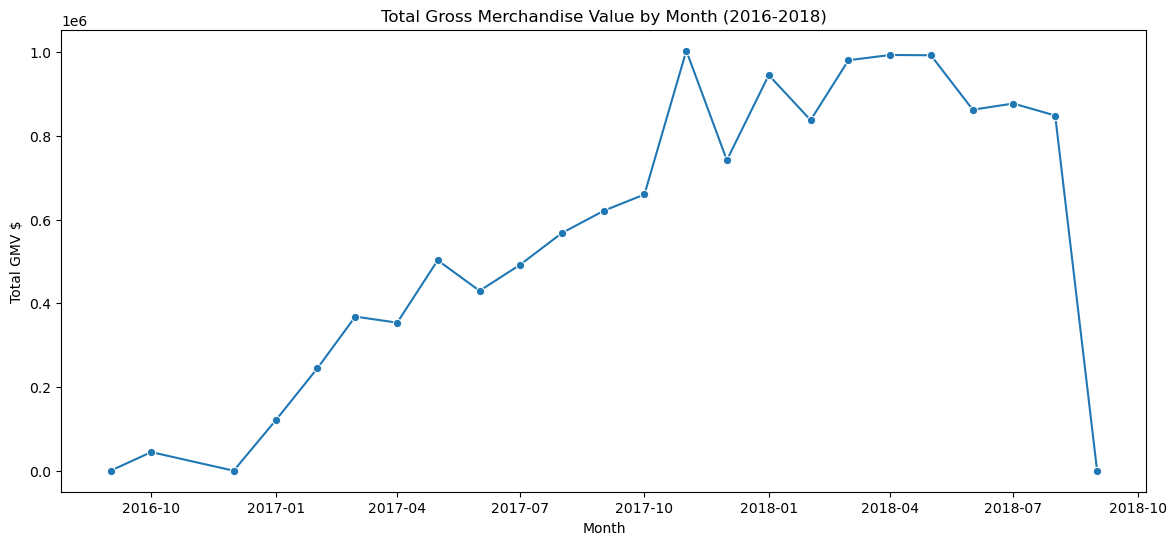

In [6]:
# Plot the GMV data 
plt.figure(figsize=(14,6))
sns.lineplot(data=df_monthly_gmv,x='purchase_month',
             y='total_gmv', marker='o')

plt.title('Total Gross Merchandise Value by Month (2016-2018)')
plt.xlabel('Month')
plt.ylabel('Total GMV $')

# Format the y-axis 


Interpretation:
- Strong Growth: The business experienced a clear growth phase, rising from near-zero GMV in 2016 to significant sales by 2018.
- New Plateau: After the 2017 holiday surge, the business settled into a new, higher plateau of stable sales throughout 2018 (Feb-July).
- The dip in August 2018 is due to data cut off. 
- Sigh of seasonal peak in the end of the year, but only visible in November 2017 (~ +50% MoM growth) and follow by a drop in Jan 2018, which strongly indicates that Black Friday is the most critical sales period.

### 3.3 Total Orders vs. Average Order Value (AOV)

In [7]:
# Query the monthly total orders and AOV
query_monthly_order ="""
SELECT 
    DATE_FORMAT(o.order_purchase_timestamp,'%Y-%m-01') as purchase_month,
    COUNT(o.order_sk) as total_order,
    SUM(i.price) as total_gmv,
    (SUM(i.price) / COUNT(DISTINCT o.order_sk)) as aov
FROM fct_order_items as i 
JOIN fct_orders as o 
ON o.order_sk = i.order_sk
WHERE o.order_status NOT IN ('canceled','unavailable')
GROUP BY 1
ORDER BY 1 ASC;
"""

# Run the query 
df_monthly_order = pd.read_sql(query_monthly_order,engine)
df_monthly_order['purchase_month'] = pd.to_datetime(df_monthly_order['purchase_month'])

# Create Monthly Growth column 
df_monthly_order['mom_order'] = (df_monthly_order['total_order'].pct_change()*100).round(2)
df_monthly_order['mom_aov'] = (df_monthly_order['aov'].pct_change()*100).round(2)

display(df_monthly_order)

,purchase_month,total_order,total_gmv,aov,mom_order,mom_aov
0,2016-09-01,5,207.86,103.930000,NaN,NaN
1,2016-10-01,342,44507.30,153.473448,6740.00,47.67
2,2016-12-01,1,10.90,10.900000,-99.71,-92.90
3,2017-01-01,953,120098.27,152.602630,95200.00,1300.02
4,2017-02-01,1936,244959.35,142.584022,103.15,-6.57
5,2017-03-01,2975,368341.32,140.749454,53.67,-1.29
6,2017-04-01,2660,353842.98,148.861161,-10.59,5.76
7,2017-05-01,4105,502980.19,138.219343,54.32,-7.15
8,2017-06-01,3571,429916.61,134.139348,-13.01,-2.95
9,2017-07-01,4493,492287.30,124.756031,25.82,-7.00


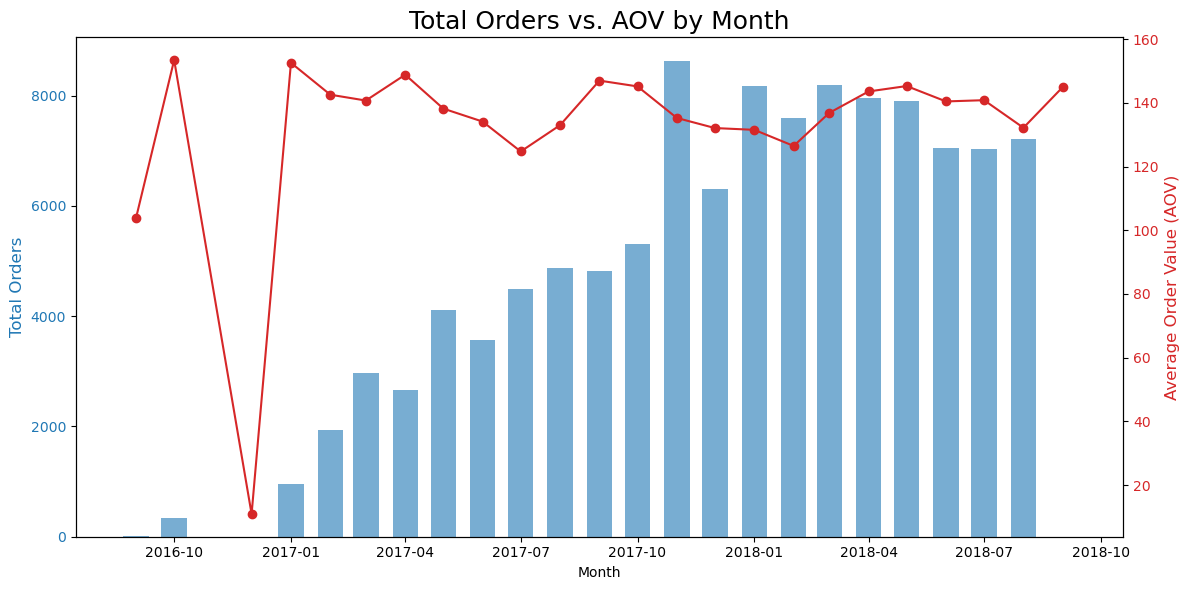

In [8]:
# Create a dual-axis chart 
# Initiate subplot 
fig, ax1 = plt.subplots(figsize=(12,6))

# Plot Total Orders 
ax1.set_title('Total Orders vs. AOV by Month',fontsize = 18)
ax1.set_xlabel('Month')
ax1.set_ylabel('Total Orders', color = 'tab:blue',fontsize = 12)

# Plot as a bar chart 
ax1.bar(df_monthly_order['purchase_month'], df_monthly_order['total_order'], alpha=0.6,label='Total Orders',width = 20)
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Plot the second Y-axis with AOV 
ax2 = ax1.twinx() 
ax2.set_ylabel('Average Order Value (AOV)', color = 'tab:red',fontsize = 12)
ax2.plot(df_monthly_order['purchase_month'], df_monthly_order['aov'], color='tab:red',marker='o',label='AOV')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.show()

Interpretation: 
- **Total Orders**: number of orders is the main driver of GMV, total orders trend also follows GMV seasonal trend. 
- **AOV**: 
    - The AOV trend remains relatively stable over time, suggesting minimal changes in pricing strategies or customer spending behavior. 
    - AOV rather decline *(MoM ~-7%)* in the peak season **(November)** could be explained by promotional discount and seasonal price reduction.

### 3.4 Freight Analysis

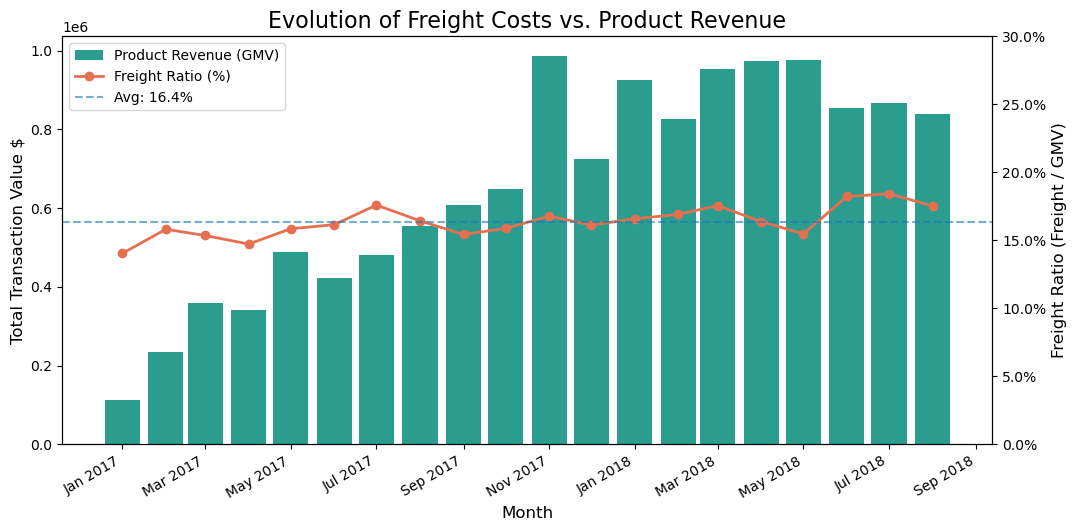

In [ ]:

# Query the monthly GMV and TMV 
query_freight = """
SELECT 
    DATE_FORMAT(o.order_purchase_timestamp,'%Y-%m-01') as purchase_month,
    SUM(i.price) as total_gmv,
    SUM(i.freight_value) as total_freight, 
    (SUM(i.price) + SUM(i.freight_value)) as total_ttv, 
    (SUM(i.freight_value) / SUM(i.price)) * 100 as freight_ratio
FROM fct_order_items as i 
JOIN fct_orders as o 
ON o.order_sk = i.order_sk
WHERE o.order_status = 'delivered'
GROUP BY 1
ORDER BY 1 ASC;
"""
# Execute query
df_freight = pd.read_sql(query_freight,engine)

# Only plot the data from 2017
df_freight['purchase_month'] = pd.to_datetime(df_freight['purchase_month'])
df_freight = df_freight[df_freight['purchase_month'] > '2016-12-31']

# Calculate the monthly average freight ratio 
avg_freight_monthly = df_freight['freight_ratio'].mean().round(2)

# Plot the chart 
fig, ax1 = plt.subplots(figsize=(12, 6))

# Stacked Area/Bar for Context (GMV vs Freight)
# We use a stacked bar to show how much of the total cost is shipping
ax1.bar(df_freight['purchase_month'], df_freight['total_gmv'], label='Product Revenue (GMV)', color='#2a9d8f', width=25)
# ax1.bar(df_freight['purchase_month'], df_freight['total_freight'], bottom=df_freight['total_gmv'], label='Freight Revenue', color='#e9c46a', width=20)

ax1.set_ylabel('Total Transaction Value $', fontsize=12)
ax1.set_xlabel('Month', fontsize=12)
ax1.set_title('Evolution of Freight Costs vs. Product Revenue', fontsize=16)

# Format Y-axis 1
# ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'R$ {x*1e-6:1.1f}M'))

# The Freight Ratio (The Insight) on the 2nd layer
ax2 = ax1.twinx()
ax2.plot(df_freight['purchase_month'], df_freight['freight_ratio'], color='#e76f51', marker='o', linewidth=2, label='Freight Ratio (%)')

ax2.set_ylabel('Freight Ratio (Freight / GMV)', fontsize=12)
ax2.tick_params(axis='y')


# Format Y-axis 2
ax2.set_ylim(0,30)
ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}%'))

# Add the average line for freight ratio
ax2.axhline(y=avg_freight_monthly, linestyle= "--", linewidth=1.5, alpha=0.6,label= f'Avg: {avg_freight_monthly:1.1f}%')

# Fix x-axis date formatting 
# ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Combine the legend from 2 layers 
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper left',frameon=True)

fig.autofmt_xdate()
plt.grid(visible=False) # Turn off grid for cleaner look
plt.show()

**Interpretation:**
- The Freight Ratio is stable for the last 2 years, hovering above **16.4%** average line. 
- Shipping costs are scaling linearly with product prices. 
- However, there's a tendency of slightly rising shipping fee since June 2018, this could be due to carrier price hikes or a shift towards selling cheaper items.

## 4. Logistics & Operations Analysis 
<a id="section-logistics"></a>

### 4.1 Operational Funnel

#### 4.1.1 Order Status Breakdown

| **Order Status** | **Definition** |
|------------------|----------------|
| **approved**     | The order has been authorized by the system or seller but hasn't begun processing yet. |
| **processing**   | The order is being prepared—items are being picked, packed, or readied for shipment. |
| **invoiced**     | A formal invoice has been issued for the order, confirming the transaction details. |
| **shipped**      | The order has left the warehouse and is in transit to the customer. |
| **delivered**    | The order has successfully reached the customer. |
| **canceled**     | The order was terminated before shipment, either by the customer or the seller. |
| **unavailable**  | The order could not be fulfilled due to stock issues or other constraints. |

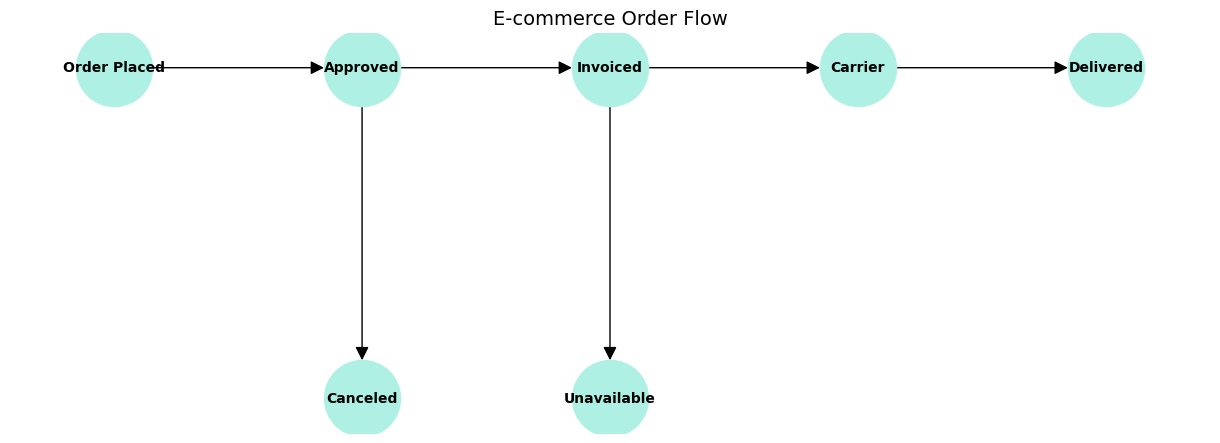

In [60]:
# Order flow
G = nx.DiGraph()
statuses = ["Order Placed", "Approved", "Invoiced", "Carrier", "Delivered", "Canceled", "Unavailable"]
G.add_nodes_from(statuses)
edges = [
    ("Order Placed", "Approved"),
    ("Approved", "Invoiced"),
    ("Invoiced", "Carrier"),
    ("Carrier", "Delivered"),
    ("Approved", "Canceled"),
    ("Invoiced", "Unavailable")
]
G.add_edges_from(edges)

pos = {
    "Order Placed": (0, 0),
    "Approved": (1, 0),
    "Invoiced": (2, 0),
    "Carrier": (3, 0),
    "Delivered": (4, 0),
    "Canceled": (1, -0.25),
    "Unavailable": (2, -0.25)
}

plt.figure(figsize=(12, 4))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="#AEF1E4", font_size=10, font_weight="bold", arrows=True, arrowstyle='-|>', arrowsize=20)
plt.title("E-commerce Order Flow", fontsize=14)
plt.tight_layout()
plt.show()

In [57]:
# Query orders by order status 
query_order_status = """
    SELECT 
        YEAR(order_purchase_timestamp) as year_purchase,
        order_status,
        COUNT(order_id) as nb_of_order,
        ROUND((COUNT(order_id)*100/
                    (SUM(COUNT(order_sk)) OVER (PARTITION BY YEAR(order_purchase_timestamp)))),2) as percentage
    FROM fct_orders 
    GROUP BY order_status, YEAR(order_purchase_timestamp)
    ORDER BY 1 ASC, 2
    ;
"""

# Execute the query and assign a df
df_order_status = pd.read_sql(query_order_status,engine)

display(df_order_status)

,year_purchase,order_status,nb_of_order,percentage
0,2016,canceled,26,7.90
1,2016,delivered,267,81.16
2,2016,invoiced,18,5.47
3,2016,processing,2,0.61
4,2016,shipped,9,2.74
5,2016,unavailable,7,2.13
6,2017,approved,2,0.00
7,2017,canceled,265,0.59
8,2017,delivered,43426,96.30
9,2017,invoiced,175,0.39


**Interpreptation:**
- **Excellent delivery rate 97%** show the excellency in operation. 
- **0.63% cancelled orders** and **0.61% unvailable orders** reveal areas for deep investigation and improvements. 

#### 4.1.2 Analyze the Funnel Breakpoint
Deepdive analysis into the reasons of failed orders ("canceled" and "unavailable" orders)

,order_status,nb_orders,gross_order_value,failure_stage
0,canceled,76,7503.94,Failed after shipping (Carrier issue)
1,canceled,141,NaN,Orders unauthorized
2,canceled,489,87731.33,Failed before shipment (Seller/Inventory issue)
3,unavailable,610,2007.69,Failed before shipment (Seller/Inventory issue)


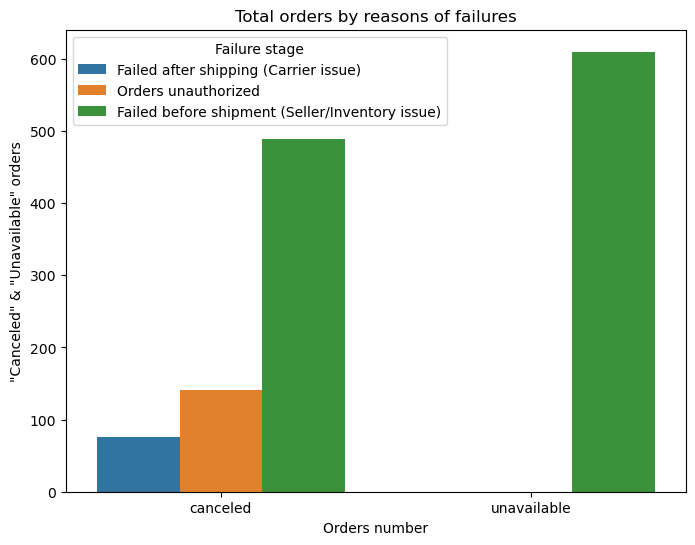

In [12]:
# Query and classified failed order
query_failed_order = """
    SELECT 
        order_status,
        COUNT(o.order_id) as nb_orders,
        ROUND(SUM(price),2) as gross_order_value,
        CASE 
            WHEN order_approved_at IS NULL THEN 'Orders unauthorized' 
            WHEN order_approved_at IS NOT NULL AND order_delivered_carrier_date IS NULL THEN 'Failed before shipment (Seller/Inventory issue)'
            WHEN order_delivered_carrier_date IS NOT NULL THEN 'Failed after shipping (Carrier issue)'
            ELSE 'Other' END AS failure_stage  
    FROM fct_orders o 
    LEFT JOIN fct_order_items i
    ON o.order_sk = i.order_sk
    WHERE order_status IN ('canceled','unavailable')
    GROUP BY 1,4
    ORDER BY 1,2 ASC
    ;
"""

# Execute the query and assign df 
df_failed_order = pd.read_sql(query_failed_order,engine)
display(df_failed_order)

# Plot the data 
plt.figure(figsize=(8,6))
ax = sns.barplot(data=df_failed_order,y='nb_orders',x='order_status', hue='failure_stage')

plt.title('Total orders by reasons of failures')
plt.ylabel('"Canceled" & "Unavailable" orders')
plt.xlabel('Orders number')
plt.legend(title='Failure stage')
plt.show()

**Interpretation:**
- **Seller/Inventory Failure is the Primary Problem:** The largest failure stage is "Failed before shipment," accounting for 1,099 orders (489 canceled + 610 unavailable). This represents **~$89.7K** in lost potential revenue and points directly to a critical operational issue with inventory management or sellers failing to fulfill paid orders.

- **Carrier Failures are High-Value:** Although fewer in number (76 orders), the "Failed after shipping" category is a significant financial drain, representing **~$7.5K** in goods that were paid for but lost in transit. The high average value of these lost orders (**$98.70**) makes this an urgent issue for the logistics team.

- **Unauthorized Orders are Standard Churn:** The 141 "Orders unauthorized" (with no gross value) are likely *normal customer churn (e.g., abandoned carts or expired payments)* and are not considered an operational failure.

In [13]:
# Query items with most failed orders
query_failed_prod = """
SELECT 
    product_sk,
    COUNT(product_sk) as item_qty, 
    SUM(price) as value
FROM fct_orders o 
LEFT JOIN fct_order_items i ON o.order_sk = i.order_sk 
WHERE order_status IN ('canceled','unavailable')
GROUP BY product_sk 
ORDER BY 2 DESC,3 DESC
LIMIT 10
;    
"""

df_failed_prod = pd.read_sql(query_failed_prod,engine)
display(df_failed_prod)


,product_sk,item_qty,value
0,16997,6,1854.00
1,11968,6,77.94
2,13271,5,1795.00
3,15295,5,1299.55
4,19753,5,900.00
5,8154,5,267.00
6,3742,5,172.50
7,25158,5,89.50
8,16239,5,49.95
9,30505,5,27.65


,product_category_name,failed_item_qty,canceled_value,gross_delivered_value
0,cool_stuff,17,14520.36,610204.10
1,sports_leisure,51,8308.05,954673.55
2,computers_accessories,46,7632.30,888613.62
3,watches_gifts,21,6820.47,1165898.98
4,auto,31,6134.38,578849.35
5,housewares,49,5422.86,615628.69
6,garden_tools,19,4246.52,470495.28
7,toys,34,4138.06,471097.49
8,musical_instruments,11,3710.44,184315.74
9,electronics,12,3167.20,155043.93


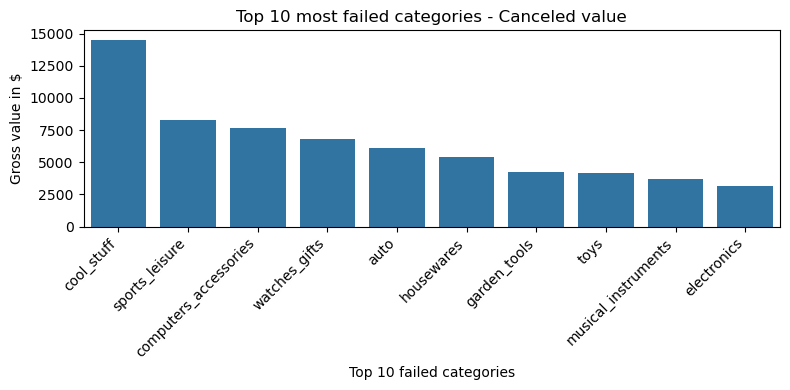

In [14]:
# Query items categories with most failed orders
query_failed_cat = """
WITH cte as 
(SELECT 
    product_category_name,
    COUNT(i.product_sk) as failed_item_qty, 
    SUM(price) as canceled_value
FROM fct_orders o 
LEFT JOIN fct_order_items i ON o.order_sk = i.order_sk 
LEFT JOIN dim_products p ON p.product_sk = i.product_sk
WHERE order_status IN ('canceled','unavailable')
GROUP BY 1
ORDER BY 3 DESC,2 DESC
LIMIT 10)
SELECT 
    cte.product_category_name,
    cte.failed_item_qty,
    cte.canceled_value,
    SUM(price) as gross_delivered_value
FROM fct_orders o 
LEFT JOIN fct_order_items i ON o.order_sk = i.order_sk
LEFT JOIN dim_products p ON p.product_sk = i.product_sk
JOIN cte ON cte.product_category_name = p.product_category_name
WHERE o.order_status IN ('delivered')
GROUP BY 1 
ORDER BY 3 DESC,2 DESC
;
    
"""

df_failed_cat = pd.read_sql(query_failed_cat,engine)
display(df_failed_cat)

# Plot the data 
# Melt the category df 
df_melted = df_failed_cat.melt(id_vars='product_category_name',
                               value_vars=['canceled_value','gross_delivered_value'],
                               var_name='metric',value_name='value')
# Plot the clustered bar chart
plt.figure(figsize=(8,4))
sns.barplot(df_failed_cat,x='product_category_name',y='canceled_value')

plt.title('Top 10 most failed categories - Canceled value')
plt.xlabel('Top 10 failed categories')
plt.ylabel('Gross value in $')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Interpreptation:**
- **"Cool stuff"** is the category with highest loss values
- **"Sport leisure"** is the most frequently lacking inventory category. 
- **"Watches_gifts"** contribute highly in the gross value but also belong to top 3 failed to delivery items 

#### 4.1.2 Calculating Average Stage times 

In [15]:
# Query the average time of each stage 
query_timings = """
    SELECT 
        AVG(TIMESTAMPDIFF(HOUR,order_purchase_timestamp,order_approved_at)) as avg_approval_time, 
        AVG(TIMESTAMPDIFF(HOUR,order_approved_at,order_delivered_carrier_date)) as avg_processing_time,
        AVG(TIMESTAMPDIFF(HOUR,order_purchase_timestamp,order_delivered_customer_date)) as avg_customer_shipping_time
    FROM fct_orders 
    WHERE order_status = 'delivered'
"""

df_timings = pd.read_sql(query_timings, engine)
    
# Melt the data for easy plotting and convert hours to days
df_timings_melted = df_timings.melt(var_name='Funnel Stage', value_name='Average Hours')
df_timings_melted['Average Days'] = df_timings_melted['Average Hours'] / 24.0
df_timings_melted['Average Days'] = df_timings_melted['Average Days'].round(1)
    
# Clean up stage names
df_timings_melted['Funnel Stage'] = df_timings_melted['Funnel Stage'].str.replace('_time', '').str.replace('avg_', '').str.title()
    
print("Average Fulfillment Stage Times:")
display(df_timings_melted)

Average Fulfillment Stage Times:


,Funnel Stage,Average Hours,Average Days
0,Approval,9.9226,0.4
1,Processing,66.6902,2.8
2,Customer_Shipping,300.8973,12.5


### 4.2 Review Score Distribution (Overall Satisfaction)
This analysis treats each review independently rather than averaging scores per order. This captures the full detail from the dataset, where one order can have multiple reviews.

In [16]:
# Query the total review scores 
query_rating = """
SELECT 
    review_score,
    COUNT(review_sk) as total_reviews, 
    ROUND((COUNT(review_sk)*100/
                                (SELECT COUNT(*) FROM fct_order_review)),2) as percentage
FROM fct_order_review
GROUP BY review_score 
ORDER BY 1
"""
df_total_rating = pd.read_sql(query_rating,engine)
display(df_total_rating)

,review_score,total_reviews,percentage
0,1,11279,11.46
1,2,3113,3.16
2,3,8097,8.23
3,4,19007,19.32
4,5,56901,57.83


review_score,1,2,3,4,5
purchase_year,,,,,
2016,14.4,2.3,8.0,19.0,56.3
2017,9.0,3.1,8.5,20.3,59.2
2018,10.3,3.0,8.0,19.3,59.4


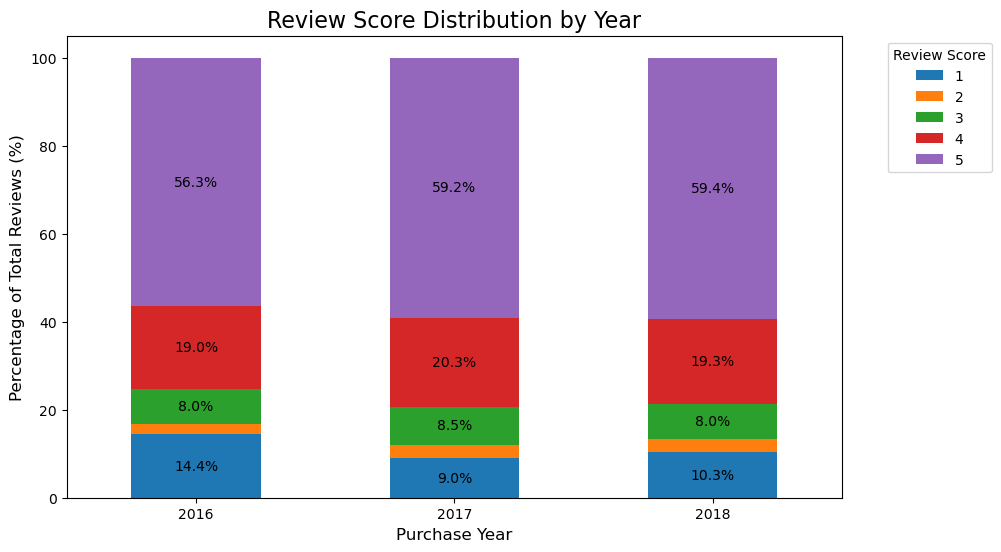

In [17]:
# Query the review score by years 
query_yearly_rating = """
SELECT 
    YEAR(order_purchase_timestamp) as purchase_year,
    review_score, 
    COUNT(review_sk) as review_count
FROM fct_order_review r
JOIN fct_orders o 
ON o.order_sk = r.order_sk
WHERE order_status = 'delivered'
GROUP BY 1,2
ORDER BY 1,2
"""
# Execute the query
df_yearly_rating = pd.read_sql(query_yearly_rating,engine)

# Plot the 100% stacked bar chart 
# Create the appropriate df
pivot_df = df_yearly_rating.pivot(index='purchase_year',columns='review_score',values='review_count')
percent_df = pivot_df.div(pivot_df.sum(axis=1),axis=0) # convert raw counts into percentages
percent_df.iloc[:,:] = round(percent_df.iloc[:,:]*100,1)
display(percent_df)

# Plot the chart 
ax = percent_df.plot(kind='bar',stacked=True,figsize=(10,6))

plt.title('Review Score Distribution by Year', fontsize=16)
plt.xlabel('Purchase Year', fontsize=12)
plt.ylabel('Percentage of Total Reviews (%)', fontsize=12)
plt.xticks(rotation = 0)
plt.legend(title='Review Score', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add percentage labels (optional but recommended)
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    if height > 5: # Only label segments larger than 5%
        x, y = p.get_xy() 
        ax.text(x + width/2, 
                y + height/2, 
                f'{height:.1f}%', 
                ha='center', 
                va='center',
                color='black')

plt.show()

**Interpretation**
- **Improved 5-Star Ratings:** The proportion of 5-star reviews (purple) grew from 56.3% in 2016 to over 59% in 2017 and 2018. This indicates the business became more consistent at delivering a better experience as it matured.

- **Reduced 1-Star Ratings:** The most significant change was the drop in 1-star reviews (blue), which fell from a high of 14.4% in 2016 to 9.0% in 2017. This suggests a successful reduction in the "very bad" shopping experiences.

- **Highly Polarized Experience:** In all years, the customer experience is highly polarized. The vast majority of reviews are either 5-star (love it), 4-star (like it), or 1-star (hate it), with very few customers leaving 2-star or 3-star reviews.

### 4.3 Calculating Total Delivery days
**_"Does a longer delivery time really lead to a worse review score?"_**


In [18]:
# Query the delivery days, days late and review score 
query_logistic = """
SELECT 
    r.review_score,
    DATEDIFF(o.order_delivered_customer_date, o.order_purchase_timestamp) as delivery_days, 
    DATEDIFF(o.order_delivered_customer_date, o.order_estimated_delivery_date) as days_late
FROM fct_orders as o 
JOIN fct_order_review as r
ON o.order_sk = r.order_sk
WHERE 
    o.order_status = 'delivered'
    AND o.order_delivered_customer_date IS NOT NULL
    AND o.order_estimated_delivery_date IS NOT NULL;
"""

# Execute the query to create the delays vs review df
df_logistics = pd.read_sql(query_logistic,engine)

display(df_logistics)

,review_score,delivery_days,days_late
0,1,55,36
1,4,23,-1
2,4,24,-11
3,3,31,-26
4,1,28,-23
...,...,...,...
95594,1,1,-4
95595,5,1,-5
95596,5,1,-12
95597,3,1,-4


In [19]:
# Group by review_score and calculate statistics for delivery_days
delivery_day_sum = df_logistics.groupby('review_score')['delivery_days'].agg(count='count',
                                                        SD ='std',
                                                        percentile_25 = lambda x: x.quantile(0.25),
                                                        median='median',
                                                        percentile_75 = lambda x: x.quantile(0.75),
                                                        average = 'mean',
                                                        min = 'min', max='max'
                                                        ).reset_index()

# Round the statistics
delivery_day_sum = delivery_day_sum.round(2)

print('Rating and delivery days distribution statistics:')
display(delivery_day_sum)

Rating and delivery days distribution statistics:


,review_score,count,SD,percentile_25,median,percentile_75,average,min,max
0,1,9291,16.11,9.0,17.0,31.0,21.29,1,196
1,2,2907,12.50,8.0,13.0,22.0,16.60,1,208
2,3,7884,9.92,8.0,12.0,18.0,14.20,1,188
3,4,18861,8.30,7.0,11.0,16.0,12.25,1,195
4,5,56656,6.83,6.0,9.0,14.0,10.62,0,187


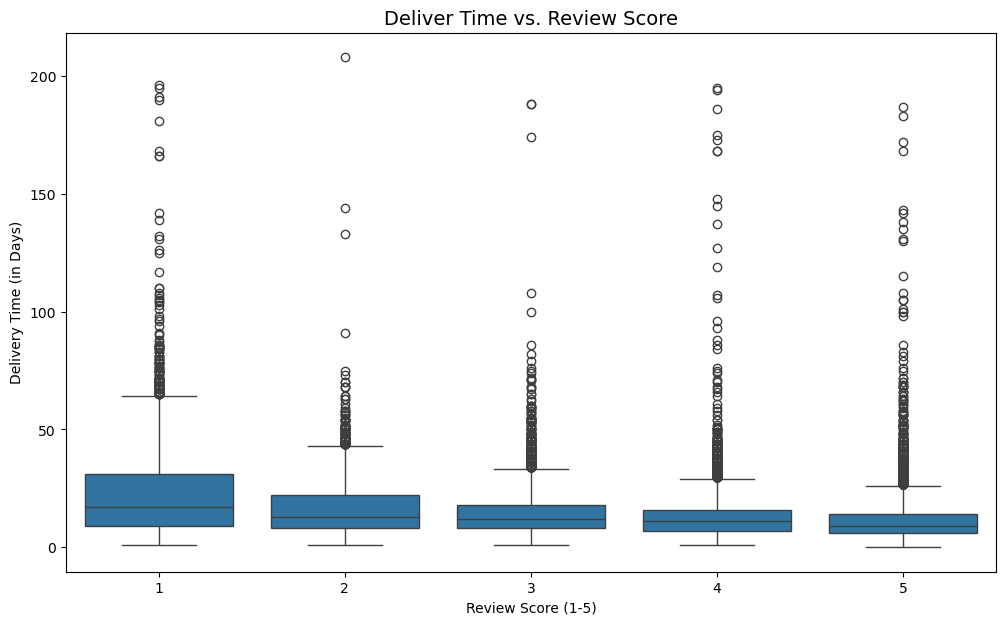

In [20]:
# Plot the data Delivery Days vs Review Score
plt.figure(figsize=(12,7))
sns.boxplot(data=df_logistics,
            x='review_score',
            y='delivery_days')

plt.title('Deliver Time vs. Review Score',fontsize=14)
plt.xlabel('Review Score (1-5)')
plt.ylabel('Delivery Time (in Days)')

plt.show()

In [21]:
# Group by review_score and calculate statistics for days_late
days_late_sum = df_logistics.groupby('review_score')['days_late'].agg(count='count',
                                                        SD ='std',
                                                        percentile_25 = lambda x: x.quantile(0.25),
                                                        median='median',
                                                        percentile_75 = lambda x: x.quantile(0.75),
                                                        average = 'mean',
                                                        min = 'min', max='max'
                                                        ).reset_index()

days_late_sum = days_late_sum.round(2)

print('Late delivery days by rating statistic:')
display(days_late_sum)


Late delivery days by rating statistic:


,review_score,count,SD,percentile_25,median,percentile_75,average,min,max
0,1,9291,16.07,-14.0,-7.0,6.0,-4.00,-69,175
1,2,2907,12.67,-15.0,-10.0,-3.0,-8.62,-56,188
2,3,7884,10.37,-16.0,-11.0,-6.0,-10.77,-135,162
3,4,18861,9.05,-17.0,-12.0,-7.0,-12.37,-75,161
4,5,56656,8.15,-18.0,-13.0,-8.0,-13.38,-147,155


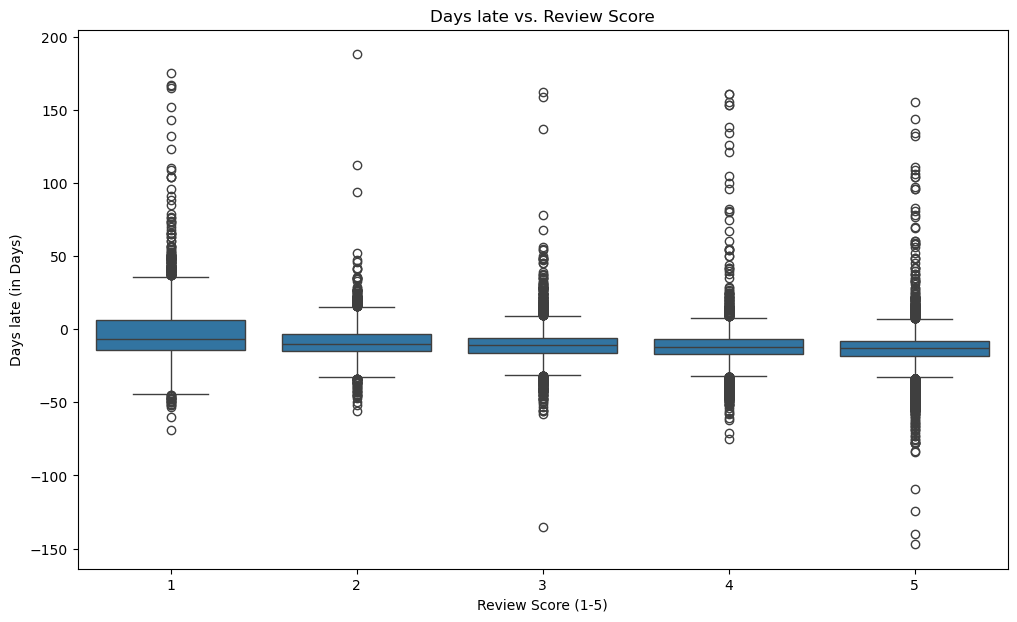

,review_score,count,SD,percentile_25,median,percentile_75,average,min,max
0,1,9291,16.07,-14.0,-7.0,6.0,-4.00,-69,175
1,2,2907,12.67,-15.0,-10.0,-3.0,-8.62,-56,188
2,3,7884,10.37,-16.0,-11.0,-6.0,-10.77,-135,162
3,4,18861,9.05,-17.0,-12.0,-7.0,-12.37,-75,161
4,5,56656,8.15,-18.0,-13.0,-8.0,-13.38,-147,155


In [22]:
# Plot the data Days late vs Review Score
plt.figure(figsize=(12,7))
sns.boxplot(data=df_logistics,
            x='review_score',
            y='days_late')

plt.title('Days late vs. Review Score')
plt.xlabel('Review Score (1-5)')
plt.ylabel('Days late (in Days)')

plt.show()
display(days_late_sum)

**Interpretation:** 
- **Delivery Duration Impact**: Longer shipping times are strongly associated with lower customer ratings. The median delivery time for 1-star reviews was **17 days**, compared to just **9 days** for 5-star reviews. Additionally, the standard deviation for 5-star deliveries was the lowest (around 1 week) indicating consistency. These trends suggest that fast and reliable delivery is essential for high customer satisfaction.
- **Customer delivery latency**: While all orders tend to arrive earlier than promised. the median for **a 1-star review is -7.0 days**, and for **a 5-star review, it's -13.0 days**. However, there're *25% 1-star orders* (historical data) which arrived later than 6 days.


## 5. Product & Category Analysis

### 5.1 Top 10 Categories and Geolocation by Gross Revenue 


Top 10 All time Categories by GMV


,product_category_name,total_revenue,percentage
0,health_beauty,1.233132e+06,9.33
1,watches_gifts,1.165899e+06,8.82
2,bed_bath_table,1.023435e+06,7.74
3,sports_leisure,9.546736e+05,7.22
4,computers_accessories,8.886136e+05,6.72
5,furniture_decor,7.119277e+05,5.39
6,housewares,6.156287e+05,4.66
7,Other,6.626940e+06,50.12


<Figure size 600x600 with 0 Axes>

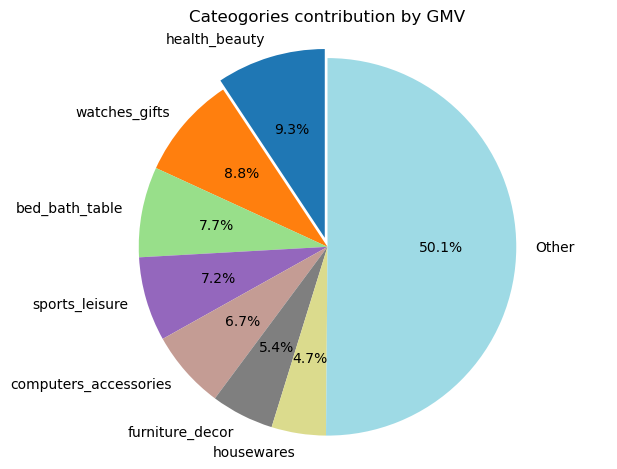

In [23]:
# Query top 10 Categories by GMV
query_top_cat = """
    WITH cte as (
        SELECT SUM(price) as total_GMV
        FROM fct_order_items i 
        JOIN fct_orders o ON o.order_sk = i.order_sk  
        WHERE order_status = 'delivered'
    ),
    top7 as
    (
    SELECT 
        product_category_name,
        SUM(price) as total_revenue,
        ROUND((SUM(price)*100/(SELECT * FROM cte)),2) as percentage
    FROM fct_order_items i 
    JOIN fct_orders o ON o.order_sk = i.order_sk 
    JOIN dim_products p ON p.product_sk = i.product_sk 
    WHERE order_status = 'delivered'
    AND p.product_category_name IS NOT  NULL
    GROUP BY p.product_category_name
    ORDER BY 2 DESC
    LIMIT 7
    )
    
    SELECT * FROM top7
    UNION ALL
    (
    SELECT 
        'Other' as product_category_name, 
        (SELECT * FROM cte) - (SELECT SUM(total_revenue) FROM top7) as total_revenue,
        100 - (SELECT SUM(percentage) FROM top7) as percentage 
    FROM cte
    )
    
    ;
"""
# Execute the query and assign a df 
df_top_cat = pd.read_sql(query_top_cat,engine)
print("Top 10 All time Categories by GMV")
display(df_top_cat)

# Plot the pie chart 
plt.figure(figsize=(6,6))
values = pd.to_numeric(df_top_cat['total_revenue'],errors='coerce').fillna(0).tolist()
explode = [0.05] + [0]*(len(values)-1) 
df_top_cat.plot(kind='pie',labels=df_top_cat['product_category_name'],y='total_revenue', autopct='%1.1f%%',
                startangle=90, explode=explode,
                legend=False,colormap='tab20')

plt.title('Cateogories contribution by GMV')
plt.axis('equal')
plt.ylabel('')
plt.tight_layout()
plt.show()


**Interpretation**
- The business is not reliant on just a few categories, signaling a generalist platform.
- **"Hero" categories:** `health_beauty` (9.3%) and `watches_gifts` (8.8%) are the strongest individual segments.

### 5.2 Top players by geolocation

In [24]:
# Query the locations 
query_location = """
    SELECT
        COUNT(DISTINCT customer_city) as nb_city,
        COUNT(DISTINCT customer_state) as nb_state
    FROM dim_customers
"""
# Run the query 
df_location = pd.read_sql(query_location,engine)
display(df_location)

,nb_city,nb_state
0,3781,25


In [25]:
# Query top cities with highest value 
query_top_cities = """
    WITH cte as (
        SELECT SUM(price) as total_GMV
        FROM fct_order_items i 
        JOIN fct_orders o ON o.order_sk = i.order_sk  
        WHERE order_status = 'delivered'
    ),
    ranked_city as
    (SELECT 
        customer_city, 
        SUM(price) as total_revenue
    FROM fct_order_items i 
    JOIN fct_orders o ON i.order_sk = o.order_sk
    JOIN dim_customers c ON c.customer_sk = o.customer_sk 
    WHERE o.order_status = 'delivered'
    GROUP BY c.customer_city
    ORDER BY 2 DESC
    ),
    top7 as 
    (SELECT * FROM ranked_city LIMIT 7
    ),
    other as (
    SELECT 
        'Other cities' as customer_city,
        SUM(total_revenue) as total_revenue
    FROM (SELECT * FROM ranked_city WHERE customer_city NOT IN (SELECT customer_city FROM top7)) as remainder
    ),
    combined as (
    SELECT * FROM top7
    UNION ALL 
    SELECT * FROM other
    )
        
    SELECT 
        customer_city, total_revenue,
        ROUND(total_revenue*100/(SELECT * FROM cte),2) as percentage
    FROM combined;
"""
# Execute the query 
df_top_city = pd.read_sql(query_top_cities,engine)
display(df_top_city)

,customer_city,total_revenue,percentage
0,New York,133770.49,1.01
1,Chicago,129651.96,0.98
2,Kansas City,99765.97,0.75
3,Phoenix,86724.80,0.66
4,Birmingham,82078.55,0.62
5,Saint Louis,77939.52,0.59
6,Aurora,56163.25,0.42
7,Other cities,12554154.39,94.96


#

In [26]:
# Query top states with highest value 
query_top_states = """
    WITH cte as (
        SELECT SUM(price) as total_GMV
        FROM fct_order_items i 
        JOIN fct_orders o ON o.order_sk = i.order_sk  
        WHERE order_status = 'delivered'
    ),
    ranked_state as
    (SELECT 
        customer_state, 
        SUM(price) as total_revenue
    FROM fct_order_items i 
    JOIN fct_orders o ON i.order_sk = o.order_sk
    JOIN dim_customers c ON c.customer_sk = o.customer_sk 
    WHERE o.order_status = 'delivered'
    GROUP BY c.customer_state
    ORDER BY 2 DESC
    ),
    top7 as 
    (SELECT * FROM ranked_state LIMIT 7
    ),
    other as (
    SELECT 
        'Other states' as customer_state,
        SUM(total_revenue) as total_revenue
    FROM (SELECT * FROM ranked_state WHERE customer_state NOT IN (SELECT customer_state FROM top7)) as remainder
    ),
    combined as (
    SELECT * FROM top7
    UNION ALL 
    SELECT * FROM other
    )
        
    SELECT 
        customer_state, total_revenue,
        ROUND(total_revenue*100/(SELECT * FROM cte),2) as percentage
    FROM combined;
"""
# Execute the query 
df_top_states = pd.read_sql(query_top_states,engine)
display(df_top_states)

,customer_state,total_revenue,percentage
0,New York,1722738.92,13.03
1,Illinois,1351269.44,10.22
2,Missouri,1047535.56,7.92
3,Iowa,997453.88,7.54
4,North Carolina,700984.79,5.30
5,Indiana,697538.67,5.28
6,Kentucky,653378.59,4.94
7,Other states,6049349.08,45.76


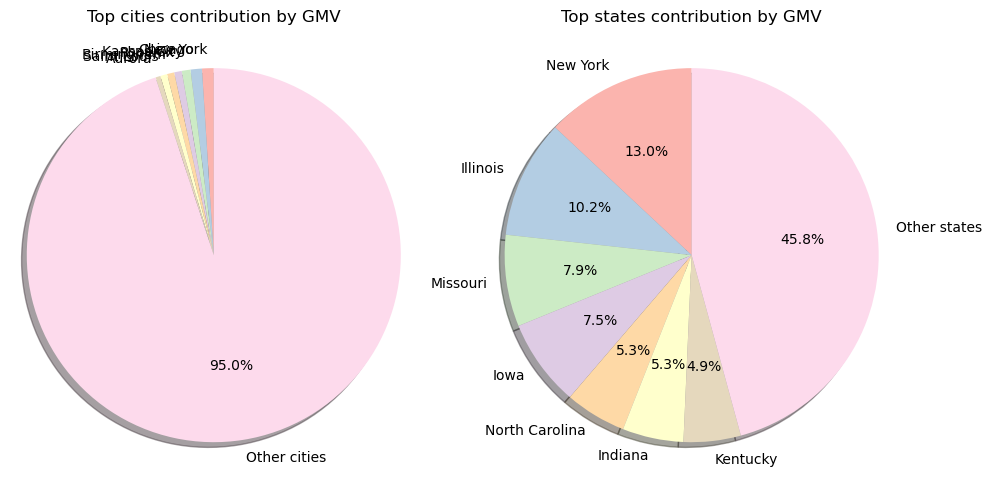

In [27]:
# Plot a charts with subplots 
fig,ax = plt.subplots(1,2, figsize=(10,5))

def autopct_filter(pct):
    return f'{pct:.1f}%' if pct > 3 else ''


# Plot pie charts for cities 
ax[0].pie(df_top_city['total_revenue'],labels=df_top_city['customer_city'],autopct=autopct_filter, startangle=90,
          shadow=True, colors=plt.get_cmap('Pastel1').colors)
ax[0].set_title('Top cities contribution by GMV')
ax[0].axis('equal')
ax[0].set_ylabel('')

# Plot pie charts for states 
ax[1].pie(df_top_states['total_revenue'],labels=df_top_states['customer_state'],autopct=autopct_filter, startangle=90,
          shadow=True, colors=plt.get_cmap('Pastel1').colors)
ax[1].set_title('Top states contribution by GMV')
ax[1].axis('equal')
ax[1].set_ylabel('')

\

plt.tight_layout()
plt.show()

**Interpretation**
- **New York (13.0%)** and **Illinois (10.2%)** are major revenue drivers.
- The business does not rely on a few big metropolitan areas. Instead, your revenue comes from many small customers spread across a few key states.

### 5.3 Top Sellers by GMV

In [28]:
# Query top sellers 
query_top_sellers = """
SELECT 
    s.seller_id,
    SUM(i.price) AS total_revenue,
    COUNT(DISTINCT i.order_sk) AS total_orders
FROM 
    fct_order_items i
JOIN 
    dim_sellers s ON i.seller_sk = s.seller_sk
GROUP BY 
    s.seller_id
ORDER BY 
    total_revenue DESC
LIMIT 10;
"""
# Execute the query
df_top_sellers = pd.read_sql(query_top_sellers, engine)
    
print("Top 10 Sellers by Total Revenue:")
display(df_top_sellers)

Top 10 Sellers by Total Revenue:


,seller_id,total_revenue,total_orders
0,4869f7a5dfa277a7dca6462dcf3b52b2,229472.63,1132
1,53243585a1d6dc2643021fd1853d8905,222776.05,358
2,4a3ca9315b744ce9f8e9374361493884,200472.92,1806
3,fa1c13f2614d7b5c4749cbc52fecda94,194042.03,585
4,7c67e1448b00f6e969d365cea6b010ab,187923.89,982
5,7e93a43ef30c4f03f38b393420bc753a,176431.87,336
6,da8622b14eb17ae2831f4ac5b9dab84a,160236.57,1314
7,7a67c85e85bb2ce8582c35f2203ad736,141745.53,1160
8,1025f0e2d44d7041d6cf58b6550e0bfa,138968.55,915
9,955fee9216a65b617aa5c0531780ce60,135171.70,1287


### 5.4 Payments table exploration
#### 5.4.1 Payments method analysis

In [29]:
# Query payments method 
query_payments = """
SELECT 
    payment_type,
    COUNT(*) AS total_transactions,
    SUM(payment_value) AS total_value
FROM 
    fct_order_payment
GROUP BY 
    payment_type
ORDER BY 
    total_transactions DESC;
"""

df_payments = pd.read_sql(query_payments, engine)
df_payments['percentage'] = (df_payments['total_transactions'] / df_payments['total_transactions'].sum()) * 100
    
print("Payment Method Distribution:")
display(df_payments)

Payment Method Distribution:


,payment_type,total_transactions,total_value,percentage
0,credit_card,76785,1.254055e+07,73.922001
1,bank_bill_pay,19782,2.869186e+06,19.044410
2,voucher,5775,3.794369e+05,5.559674
3,debit_card,1528,2.176356e+05,1.471027
4,not_defined,3,0.000000e+00,0.002888


**Interpretation:**
- Credit Card Dominance:accounting for ~74% of all transactions. 
- `bank_bill_pay` importance.

#### 5.4.2 Payment Installament Analysis 

In [30]:
query_installment = """
SELECT 
    payment_installments,
    COUNT(*) AS total_transactions,
    AVG(payment_value) AS avg_value
FROM 
    fct_order_payment
WHERE 
    payment_type = 'credit_card' -- Only installments on credit cards matter
GROUP BY 
    payment_installments
ORDER BY 
    payment_installments
    ;
"""

df_installments = pd.read_sql(query_installment, engine)
df_installments['percentage'] = (df_installments['total_transactions'] / df_installments['total_transactions'].sum()) * 100
df_installments['percentage'] = df_installments['percentage'].round(2)
    
print("Payment Installment Distribution:")
display(df_installments)

Payment Installment Distribution:


,payment_installments,total_transactions,avg_value,percentage
0,0,2,94.315000,0.00
1,1,25453,95.872093,33.15
2,2,12413,127.228150,16.17
3,3,10459,142.538570,13.62
4,4,7096,163.966881,9.24
5,5,5238,183.477316,6.82
6,6,3919,209.840766,5.10
7,7,1625,187.724012,2.12
8,8,4268,307.737427,5.56
9,9,644,203.440870,0.84


**Interpretation:**
- **Paid in full** is the dominant payment installment (33.15%). However, a significant portion of customers (over 30%) choose to pay in 2, 3, or 4 installments.
- The avg_value (average order value) directly increases with the number of installments.
    - 1 Installment: avg_value is $ 95.87.
    - 10 Installments: avg_value jumps to $ 415.13.
    - 24 Installments: avg_value is $ 610.04. 
- Multi installment offer enables customers to purchase high-value items. 

#### 5.4.3 Multi-Payment Transaction analysis 

In [31]:
# Query all orders that used more than one payment method 
query_multi_payment = """
SELECT
    order_sk,
    COUNT(DISTINCT payment_sequential) as nb_of_method,
    GROUP_CONCAT(payment_type SEPARATOR ', ') as payment_combo,
    SUM(payment_value) as total_value
FROM fct_order_payment
GROUP BY order_sk
HAVING COUNT(DISTINCT payment_sequential) > 1
ORDER BY 2 DESC, 4 DESC
;
"""

df_multi_payment = pd.read_sql(query_multi_payment,engine)
display(df_multi_payment)

,order_sk,nb_of_method,payment_combo,total_value
0,7027,29,"voucher, voucher, voucher, voucher, voucher, v...",457.99
1,12454,26,"voucher, credit_card, voucher, voucher, vouche...",62.68
2,41674,22,"voucher, voucher, voucher, voucher, voucher, v...",40.85
3,20068,21,"voucher, voucher, voucher, voucher, voucher, v...",161.32
4,26583,19,"voucher, credit_card, voucher, voucher, vouche...",205.74
...,...,...,...,...
2956,32075,2,"voucher, credit_card",16.05
2957,71876,2,"voucher, credit_card",15.18
2958,93981,2,"credit_card, voucher",14.89
2959,84892,2,"voucher, voucher",11.56


**Interpretation:**
- Payment sequential usually account for vouchers, proving that vouchers are successfully driving and enabling sales.

## 6. Customers Analysis & RFM 


## 7. Summary of Key findings
This exploratory analysis of the dataset has revealed critical insights into sales drivers, operational performances, and customer behavior.

##### 1. Sales & Growth
* **Volume-Driven Growth:** The business has seen significant growth from 2017 to 2018. This growth is correlated strongly with **Total Orders**, while the **Average Order Value (AOV)** has remained relatively flat (*~$ 120-150*).
* **Seasonality and Black Friday:** November 2017 marked a significant seasonal peak, confirming that promotional events are the primary driver of annual revenue spikes.

##### 2. Logistics & Operations (Critical)
* **Customer reference by rating:** Customer satisfaction is driven less by pure speed and more by **execeding their expectations and remaining consistency**.
    * **5-Star Reviews:** Orders typically arrive **13 days early** (median).
    * **1-Star Reviews:** Orders are unpredictable, with a median of **7 days early** but a high variance that includes significant lateness.
* **The "Funnel Break":** The most expensive operational failure is **"Paid but Not Shipped"**. Over 1,000 orders failed *after* payment due to seller/inventory issues, representing a major revenue leak (~$ 90k).

##### 3. Product Strategy
* **High-Value vs. High-Risk:**
    * **`health_beauty`** and **`watches_gifts`** are the revenue engines.
    * **`cool_stuff`** is the highest-risk category, with the largest total value of canceled orders ($ 14k), despite low volume.
* **The "Long Tail":** 50% of revenue comes from the "Other" category, indicating a healthy, diversified marketplace not reliant on a single niche.

##### 4. Freight charges & Payments
* **The "Freight Tax":** Customers pay a consistent "tax" of **~16.4%** on top of the product price for shipping. This ratio began creeping up in mid-2018, a warning sign for conversion rates.
* **Credit Drives Value:** There is a perfect correlation between installments and ticket size. Customers paying in **10+ installments** spend **4x more** than those paying upfront.